# Big Data Handling Strategies: Assignment Notebook

## 1. Setup and Introduction

* **Purpose:** Briefly state the objective of this notebook (i.e., to implement and compare strategies for handling large datasets).
* **Libraries:** Import all necessary Python libraries.

In [2]:
import pandas as pd
import numpy as np
import os
import dask.dataframe as dd
from IPython.display import display # Just use for display purpose
import psutil
import time
import csv
import polars as pl
import threading

## 2. Dataset Details

* **Source:** [Spotify Songs Dataset on Kaggle](https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics)  
* **Size:** 1.2GB  
* **Records:** ~1,000,000 rows  
* **Domain:** Music / Entertainment  

## 3. Load and Inspect Data

- Use `pandas.read_csv()` to initially load a sample of the dataset.
- Display the following:
  - First few rows (`head()`)
  - Shape of the dataset
  - Column names
  - Data types of each column
- Mention if you’re using **Google Colab** and how the file was uploaded (e.g., via Kaggle CLI, manual upload, or Google Drive mount).

Step 1: Import kaggle.json

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jialegoh","key":"7c1b959baed23f4650fbd5d73877a5de"}'}

Step 2: Move it to the correct location

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Step 3: Download Dataset from Kaggle

In [ ]:
!kaggle datasets download -d bwandowando/spotify-songs-with-attributes-and-lyrics

Dataset URL: https://www.kaggle.com/datasets/bwandowando/spotify-songs-with-attributes-and-lyrics
License(s): CC-BY-NC-SA-4.0
100% 891M/894M [00:12<00:00, 212MB/s]
100% 894M/894M [00:12<00:00, 77.5MB/s]


Step 4: Unzip the file

In [ ]:
!unzip spotify-songs-with-attributes-and-lyrics.zip

Archive:  spotify-songs-with-attributes-and-lyrics.zip
  inflating: songs_with_attributes_and_lyrics.csv  
  inflating: songs_with_lyrics_and_timestamps.csv  


Step 5: Read the csv and display rows, shape, column and data types of each column

In [ ]:
df = pd.read_csv('songs_with_attributes_and_lyrics.csv', nrows=1000000)
df['lyrics_short'] = df['lyrics'].astype(str).str.slice(0, 100) + '...'

print("First 5 rows of the dataset:")
display(df.drop(columns=['lyrics']).head())
df = df.drop(columns=['lyrics_short'])

print(f"\nDataset Shape:\nRows: {df.shape[0]}, Columns: {df.shape[1]}")

# print("\nColumn Names:")
# for col in df.columns:
#     print(f"- {col}")

print("\nColumn Names and Data Types:")
display(df.dtypes.to_frame(name='Data Type'))

print("\nSummary Info:")
df.info()

First 5 rows of the dataset:


,id,name,album_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,lyrics_short
0,0Prct5TDjAnEgIqbxcldY9,!,UNDEN!ABLE,['HELLYEAH'],0.415,0.6050,7,-11.157,1,0.0575,0.00116,0.838000,0.4710,0.193,100.059,79500.0,"He said he came from Jamaica,\n he owned a cou..."
1,2ASl4wirkeYm3OWZxXKYuq,!!,NaN,Yxngxr1,0.788,0.6480,7,-9.135,0,0.3150,0.90000,0.000000,0.1760,0.287,79.998,114000.0,"Fucked a bitch, now she running with my kids\n..."
2,69lcggVPmOr9cvPx9kLiiN,!!! - Interlude,Where I Belong EP,['Glowie'],0.000,0.0354,7,-20.151,0,0.0000,0.90800,0.000000,0.4790,0.000,0.000,11413.0,"Oh, my God, I'm going crazy\n ..."
3,4U7dlZjg1s9pjdppqZy0fm,!!De Repente!!,Un Palo Al Agua (20 Grandes Canciones),['Rosendo'],0.657,0.8820,5,-6.340,1,0.0385,0.00740,0.000013,0.0474,0.939,123.588,198173.0,Continuamente se extraña la gente si no puede ...
4,4v1IBp3Y3rpkWmWzIlkYju,!!De Repente!!,Fuera De Lugar,['Rosendo'],0.659,0.8930,5,-8.531,1,0.0411,0.09220,0.000019,0.0534,0.951,123.600,199827.0,Continuamente se extraña la gente si no puede ...



Dataset Shape:
Rows: 955320, Columns: 17

Column Names and Data Types:


,Data Type
id,object
name,object
album_name,object
artists,object
danceability,float64
energy,float64
key,object
loudness,float64
mode,object
speechiness,float64



Summary Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                955320 non-null  object 
 1   name              955309 non-null  object 
 2   album_name        385557 non-null  object 
 3   artists           955318 non-null  object 
 4   danceability      955320 non-null  float64
 5   energy            955320 non-null  float64
 6   key               955320 non-null  object 
 7   loudness          955320 non-null  float64
 8   mode              955320 non-null  object 
 9   speechiness       955320 non-null  float64
 10  acousticness      955320 non-null  float64
 11  instrumentalness  955320 non-null  float64
 12  liveness          955320 non-null  float64
 13  valence           955320 non-null  float64
 14  tempo             955320 non-null  float64
 15  duration_ms       955320 non-null  float64
 16  lyric

## 3. Apply Big Data Handling Strategies

In this notebook, we apply five effective strategies to handle large datasets using traditional **pandas** for part 1, and compare three library **pandas**, **polars** and **dask** in part 2:

Part 1:
1. Load Less Data
2. Use Chunking
3. Optimize Data Types
4. Sampling
5. (Simulated) Parallel Processing Strategy with Chunk Aggregation

Part 2:
1. Pandas
2. Polars
3. Dask

Below is the function used to get memory usage.

In [3]:
def measure_performance(func, description="", *args, **kwargs):
    process = psutil.Process(os.getpid())
    total_ram = psutil.virtual_memory().total / 1024 / 1024  # MB

    cpu_percent = []

    def track_cpu():
        while not done[0]:
            cpu_percent.append(process.cpu_percent(interval=0.1))

    done = [False]
    cpu_thread = threading.Thread(target=track_cpu)
    cpu_thread.start()

    mem_before = process.memory_info().rss / 1024 / 1024  # MB
    start_time = time.time()

    try:
        result = func(*args, **kwargs)
        success = True
    except Exception as e:
        result = None
        success = False
        error_message = str(e)

    end_time = time.time()
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    done[0] = True
    cpu_thread.join()

    exec_time = round(end_time - start_time, 4)
    mem_diff_mb = mem_after - mem_before
    mem_percent_after = (mem_after / total_ram) * 100
    mem_diff_percent = (mem_diff_mb / total_ram) * 100

    if isinstance(result, dd.DataFrame):
      result = result.compute()

    if isinstance(result, (pd.DataFrame, pl.DataFrame)):
        num_records = len(result)
        throughput = round(num_records / exec_time, 2)
    else:
        throughput = None

    performance = {
        "Description": description,
        "Memory Used (MB)": round(mem_diff_mb, 2),
        "Execution Time (s)": exec_time,
        "Success": success,
        "Average CPU (%)": round(sum(cpu_percent) / len(cpu_percent), 2) if cpu_percent else 0.0,
        "Throughput (records/sec)": throughput
    }

    if not success:
        performance["Error"] = error_message

    return performance, result

### Strategy 1: Load Less Data
Load only the necessary columns or filter relevant rows during the data reading process to minimize memory consumption.

In [ ]:
def load_less_data_pandas(file_path):
    selected_columns = [
        'danceability', 'energy', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms'
    ]

    df = pd.read_csv(file_path, usecols=selected_columns)
    return df

performance_less_data, df_less_data = measure_performance(
    load_less_data_pandas,
    description="Load Less Data with Pandas",
    file_path="songs_with_attributes_and_lyrics.csv"
)

performance_df = pd.DataFrame([performance_less_data])
display(performance_df)

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Load Less Data with Pandas,79.63,19.1333,True,95.72,49929.7


### Strategy 2: Chunking
Process the data in small chunks using pandas.read_csv(chunksize=10000).

In [ ]:
# Read and concatenate chunks of 10,000 rows
def load_with_chunking(filepath):
    chunks = []
    for chunk in pd.read_csv(filepath, chunksize=10000):
        chunk.columns = chunk.columns.str.strip()
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    return df

performance_chunking, df_chunked = measure_performance(
    load_with_chunking,
    description="Chunked Load",
    filepath="songs_with_attributes_and_lyrics.csv"
)

performance_df = pd.DataFrame([performance_chunking])
display(performance_df)

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Chunked Load,1867.88,32.9102,True,94.09,29028.08


### Strategy 3: Optimized Data Type
Process the data in by convert the data with specific data type.

In [ ]:
def optimized_load(filepath, usecols=None, dtype_map=None):
    df = pd.read_csv(filepath, usecols=usecols, dtype=dtype_map)
    return df

# Define arguments for optimized_load
load_args = {
    "filepath": "songs_with_attributes_and_lyrics.csv",
    "usecols": [
        'danceability', 'energy', 'loudness', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness',
        'valence', 'tempo', 'duration_ms'
    ],
    "dtype_map": {
        'danceability': 'float32',
        'energy': 'float32',
        'loudness': 'float32',
        'speechiness': 'float32',
        'acousticness': 'float32',
        'instrumentalness': 'float32',
        'liveness': 'float32',
        'valence': 'float32',
        'tempo': 'float32',
        'duration_ms': 'float32'
    }
}

performance_optimize_load, df_optimize_load = measure_performance(
    optimized_load,
    description="Optimized Load with Dtype",
    **load_args
)

performance_df = pd.DataFrame([performance_optimize_load])
display(performance_df)

df_optimize_load.info()


,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Optimized Load with Dtype,117.87,18.7629,True,96.65,50915.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955320 entries, 0 to 955319
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   danceability      955320 non-null  float32
 1   energy            955320 non-null  float32
 2   loudness          955320 non-null  float32
 3   speechiness       955320 non-null  float32
 4   acousticness      955320 non-null  float32
 5   instrumentalness  955320 non-null  float32
 6   liveness          955320 non-null  float32
 7   valence           955320 non-null  float32
 8   tempo             955320 non-null  float32
 9   duration_ms       955320 non-null  float32
dtypes: float32(10)
memory usage: 36.4 MB


### Strategy 4: Sampling
Reduce the dataset size to reduce processing time

In [ ]:
def sampling(filepath, sample_fraction=0.1, usecols=None, dtype_map=None):
    df = pd.read_csv(filepath, usecols=usecols, dtype=dtype_map)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

# Define arguments for sampling
load_args = {
    "filepath": "songs_with_attributes_and_lyrics.csv",
    "sample_fraction": 0.1,
}

performance_sampling, df_sampling = measure_performance(
    sampling,
    description="Sampling",
    **load_args
)

performance_df = pd.DataFrame([performance_sampling])
display(performance_df)

print(f"\nRows: {df_sampling.shape[0]}")

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Sampling,1761.08,33.4599,True,98.43,2855.12



Rows: 95532


### Strategy 5: Parallel Processing with Dask
Process parallel using dask (used multiple core.)

In [ ]:
def optimized_load_dask(filepath, usecols=None, sample_fraction=None, dtype_map=None, drop_invalid_rows=False):
    # Step 1: Read CSV lazily using Dask with object dtypes to avoid early conversion errors
    safe_dtype_map = {col: 'object' for col in dtype_map} if dtype_map else None
    ddf = dd.read_csv(filepath, usecols=usecols, dtype=safe_dtype_map, on_bad_lines="skip", engine="python")

    # Step 2: Clean column names
    ddf.columns = ddf.columns.str.strip()

    # Step 3: Optional sampling
    if sample_fraction:
        ddf = ddf.sample(frac=sample_fraction, random_state=42)

    # Step 4: Parallel conversion of each column to target dtype using map_partitions
    if dtype_map:
        for col, target_type in dtype_map.items():
            # Use map_partitions to convert each partition in parallel
            ddf[col] = ddf[col].map_partitions(
                lambda s: pd.to_numeric(s, errors='coerce').astype(target_type),
                meta=(col, target_type)
            )

    # Step 5: Drop invalid rows if requested
    if drop_invalid_rows and dtype_map:
        ddf = ddf.dropna(subset=list(dtype_map.keys()))

    # Step 6: Compute final result
    df = ddf.compute()

    return df

### Library 1: Full Load with Pandas

In [ ]:
def load_full_data():
    df = pd.read_csv("songs_with_attributes_and_lyrics.csv")
    return df

performance, df = measure_performance(load_full_data, description="Load with Pandas")

performance_df = pd.DataFrame([performance])
display(performance_df)

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Load with Pandas,123.78,49.9114,True,88.89,19140.32


### Library 2: Full Load with Polars

In [ ]:
def load_with_polars(filepath):
    df = pl.read_csv(filepath)
    return df

performance_polars, df_polars = measure_performance(
    load_with_polars,
    description="Load with Polars",
    filepath="songs_with_attributes_and_lyrics.csv"
)

performance_df = pd.DataFrame([performance_polars])
display(performance_df)

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Load with Polars,1566.1,31.2896,True,22.71,30531.55


### Library 3: Full Load with Dask

In [4]:
def load_full_data_dask_and_compute(file_path):
    # Dask setup (lazy)
    ddf = dd.read_csv(
        file_path,
        assume_missing=True,
        quoting=3,
        on_bad_lines='skip',
        dtype=str
    )

    # Trigger computation and return the pandas DataFrame
    # This is where the main memory usage occurs
    df = ddf.compute()
    return df

# Measure the performance of the loading and computation
performance_dask_compute, df_dask_computed = measure_performance(
    load_full_data_dask_and_compute,
    description="Load with Dask",
    file_path="songs_with_attributes_and_lyrics.csv"
)

performance_df_compute = pd.DataFrame([performance_dask_compute])
display(performance_df_compute)

,Description,Memory Used (MB),Execution Time (s),Success,Average CPU (%),Throughput (records/sec)
0,Load with Dask,9459.42,343.7892,True,109.04,122359.85


## 4. Compare Performance

We use seaborn and matplotib to plot the diagram based on output of part 1 and 2 to compare performance between strategies and library.


### Compare between 5 strategies
1. Load Less Data
2. Use Chunking
3. Optimize Data Types
4. Sampling
5. (Simulated) Parallel Processing Strategy with Chunk Aggregation



In [ ]:
# Sample code for plotting (if you're using matplotlib/seaborn)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create DataFrame with results
strategies_data = pd.DataFrame({
    'Strategy': ['Load Less Data','Use Chunking','Optimize Data Types','Sampling','Parallel with Dask'],
    'Memory Used (MB)': [73.07, 165.15, 2.95, 61.79, 1565.71],
    'Execution Time (s)': [19.9226, 29.8092, 17.3882, 34.3492, 75.243],
    'Avg CPU (%)': [99.56, 99.07, 99.14, 97.89, 95.1],
    'Throughput (records/sec)': [47951.57, 32047.82, 54950.71, 2781.2, 12706.13]
})

# Plot bar charts
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.barplot(x="Strategy", y="Memory Used (MB)", data=strategies_data, ax=axes[0, 0])
sns.barplot(x="Strategy", y="Execution Time (s)", data=strategies_data, ax=axes[0, 1])
sns.barplot(x="Strategy", y="Avg CPU (%)", data=strategies_data, ax=axes[1, 0])
sns.barplot(x="Strategy", y="Throughput (records/sec)", data=strategies_data, ax=axes[1, 1])

for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=15)

plt.tight_layout()
plt.show()

### Compare between 3 library
1. Pandas
2. Polars
3. Dask

<ipython-input-6-4c2c66e5d158>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
<ipython-input-6-4c2c66e5d158>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
<ipython-input-6-4c2c66e5d158>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
<ipython-input-6-4c2c66e5d158>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


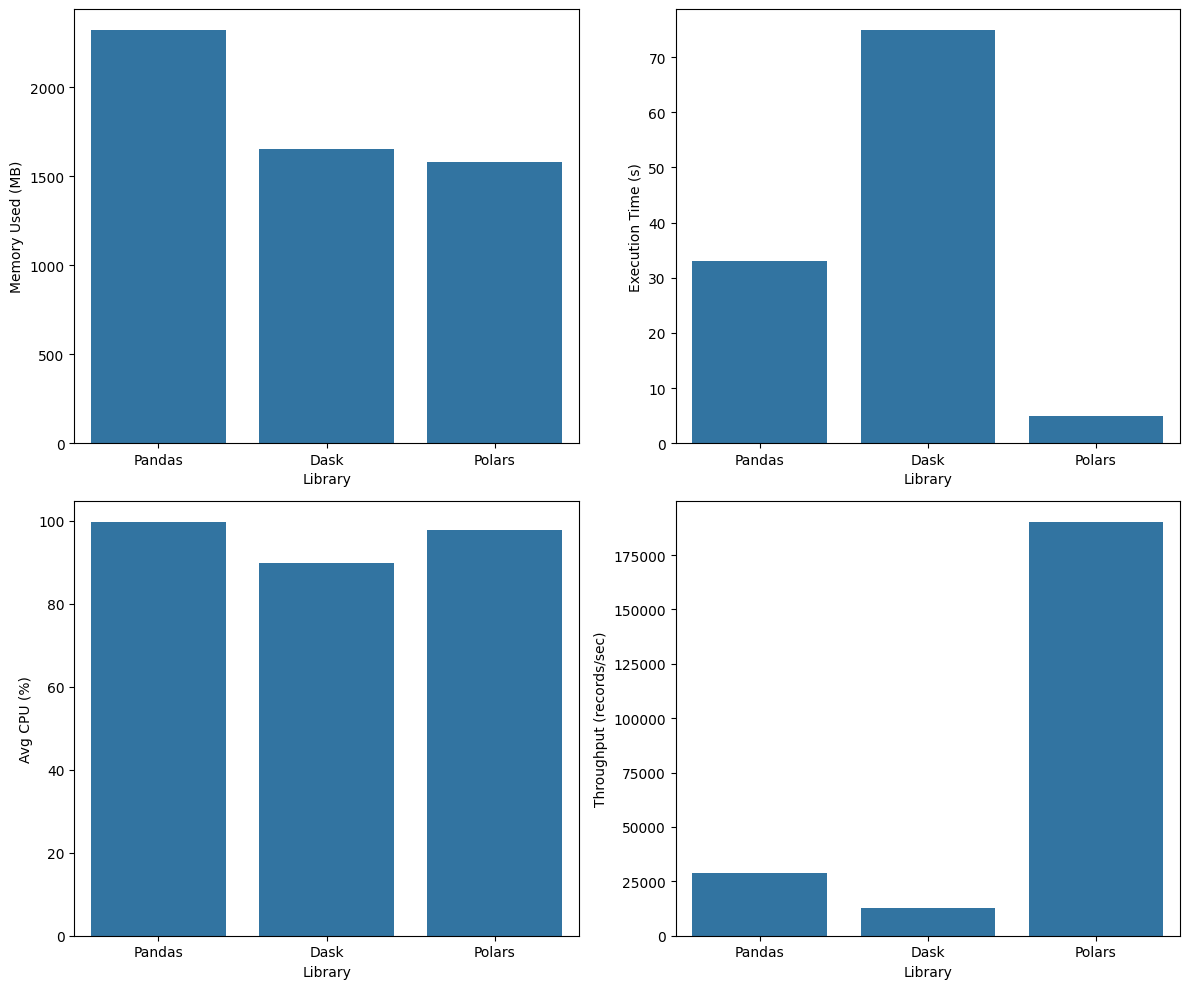

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

library_data = pd.DataFrame({
    'Library': ['Pandas', 'Dask', 'Polars'],
    'Memory Used (MB)': [2324.79, 1653.96, 1579.88],
    'Execution Time (s)': [32.9665, 74.9795, 5.0251],
    'Avg CPU (%)': [99.66, 89.78, 97.89],
    'Throughput (records/sec)': [28978.51, 12750.78, 190109.65]
})

# Bar plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
sns.barplot(x="Library", y="Memory Used (MB)", data=library_data, ax=axes[0, 0])
sns.barplot(x="Library", y="Execution Time (s)", data=library_data, ax=axes[0, 1])
sns.barplot(x="Library", y="Avg CPU (%)", data=library_data, ax=axes[1, 0])
sns.barplot(x="Library", y="Throughput (records/sec)", data=library_data, ax=axes[1, 1])

for ax in axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()